# Proyecto Final

***Equipo 07***

- Aide Jazmín González Cruz
- Elena Villalobos Nolasco
- Carolina Acosta Tovany

#### Instrucciones

El proyecto/examen final consistirá en:

La implementación del algoritmo de filtrado colaborativo utilizando la metodología vista en clase (uso de otra metodología no se calificará).

Todos los algoritmos de aprendizaje de máquina que se utilicen deberán haber sido creados por ustedes. Sólo podrán utilizar Transformers y funciones de apoyo de scikit-learn (para realizar la división de los datos en entrenamiento y prueba, o el procedimiento de validación cruzada, etc.) mas ningún estimator (regresión logística, máquina de vectores de soporte, k medias, etc.). 

Se deberá explicar como se obtuvo la k con la que se generó el resultado final.

Se utilizarán los archivos con el conjunto pequeño de calificaciones y películas ubicado en la siguiente https://www.kaggle.com/rounakbanik/the-movies-dataset:

- **links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

- **ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.

Con el fin de mejorar la calificación (opcional, puntos extra), se podrán utilizar los algoritmos desarrollado en las tareas del curso y los datos relevantes (los que hacen match con los datos anteriores) contenidos en los archivos:

- **movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

- **keywords.csv**: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

- **credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

La métrica con la que se determinará el desempeño del algoritmo es el NDCG 

(https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG)

Una vez obtenida la matriz de calificaciones, el programa deberá ser capaz de regresar las 5 mejores recomendaciones del o de los usuarios que se consulten.

El proyecto se entregará en un Jupyter notebook. El readme file debe contener las instrucciones para que se ejecute el código. Deben cerciorarse que siguiendo esas instrucciones el programa corre sin errores. 

Se deberá subir a la carpeta proyecto_final/equipo_xx en el repositorio GitHub antes de las 7:00 am del día del examen final (14 de diciembre de 2020).    

In [1]:
# Importación de paqueterías necesarias
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Importación de paqueterías creadas por nosotras
from sis_recom import load_data 
from sis_recom import create_train_test, fun_ECM

La función objetivo:
    
$$J(X) = \frac{1}{2} \displaystyle\sum_{(a,i)\in\mathbb{D}} \left(Y_{ai}-\left [ UV^T \right ]_{ai} \right)^2 + \frac{\lambda}{2} \displaystyle\sum_{a=1}^n \displaystyle\sum_{j=1}^k U_{aj}^2 + \frac{\lambda}{2} \displaystyle\sum_{i=1}^m \displaystyle\sum_{j=1}^k V_{ij}^2$$

#### Ya derivadas e igualadas a cero dependiendo de los usuarios e items:

$$x_u^T = r_uY\left(Y^TY+\lambda_xI^{-1}\right)$$

$$y_i^T = r_iX\left(X^TX+\lambda_yI^{-1}\right)$$

In [3]:
# Cargamos datos ya limpios
ratings, bases_nombres_id, arr_movies = load_data()

In [4]:
ratings.head()

,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
n_users, n_items = ratings.shape

In [6]:
n_users, n_items

(671, 9125)

In [7]:
# Separando datos en train y test
train, test = create_train_test(np.array(ratings))

In [8]:
train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [9]:
test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
class Matrix_Factorization:
    """
    Factorización de matrices para predecir entradas vacías en una matriz
    
    Parametros
    ----------
    n_iters : numero de iteraciones para entregar algoritmo
        
    k : rank de la matriz
        
    _lambda : regularización
    """
    
    def __init__(self, n_iters, k, _lambda):
        self._lambda = _lambda
        self.n_iters = n_iters
        self.k = k  
        
    def fit(self, train, test):
        """
        partición de entrenamiento y test
        y selección de vectores aleatorios
        """
        self.n_user, self.n_item = train.shape
        
        self.user_factors = np.random.random((self.n_user, self.k))
        self.item_factors = np.random.random((self.n_item, self.k))
        
        self.test_ecm_record  = []
        self.train_ecm_record = []
        
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
            predictions = self.predict()
            test_ecm = self.compute_ecm(test, predictions)
            train_ecm = self.compute_ecm(train, predictions)
            self.test_ecm_record.append(test_ecm)
            self.train_ecm_record.append(train_ecm)
        
        return self    
    
    def _als_step(self, ratings, vec_res, vec_fij):
        """
        función que obtiene los vectores X_u ó Y_i
        """
        A = vec_fij.T.dot(vec_fij) + np.eye(self.k) * self._lambda
        b = ratings.dot(vec_fij)
        A_inv = np.linalg.inv(A)
        vec_res = b.dot(A_inv)
        return vec_res
    
    def predict(self):
        """Predicción de matris completa"""
        pred = self.user_factors.dot(self.item_factors.T)
        return pred
    
    @staticmethod
    def compute_ecm(y_true, y_pred):
        mask = np.nonzero(y_true)
        ecm = fun_ECM(y_true[mask], y_pred[mask])

        return ecm

In [19]:
als = Matrix_Factorization(n_iters = 15, k = 36, _lambda = 0.01)
als.fit(train, test)

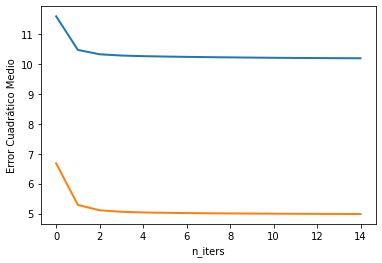

In [20]:
plt.plot(als.test_ecm_record, label = 'Test', linewidth = 2)
plt.plot(als.train_ecm_record, label = 'Train', linewidth = 2)
plt.xlabel('iteraciones')
plt.ylabel('Error Cuadrático Medio')
plt.show()

Observamos que con muy pocas iteraciones el ECM baja, por lo que en las siguientes evaluaciones utilizaremos 15 iteraciones.

### Cross Validation

Ahora realizamos el método de Cross Validation para obtener la mejor k.

In [21]:
n_folds = 5

In [22]:
K_list = [10,71,171,271,371,471,571,671]

In [29]:
#K_list = []
#for i in range(1, train.shape[0], 10):
#for i in range(1, train.shape[0], 100):
#    K_list.append(i)

In [24]:
K_list

[10, 71, 171, 271, 371, 471, 571, 671]

In [25]:
df_k = pd.DataFrame(0.0, index=range(1), columns=K_list)
data = train

In [26]:
data.shape

(671, 9125)

In [27]:
# Dividimos los datos en chunk de igual tamaño de forma vertical
chunks = np.hsplit(data, n_folds)
for k in K_list:
    error = 0.0
    for i in range(1, int(n_folds)):

        # El chunk i será nuestro bloque de datos de prueba
        test_data = chunks[i]

        # Entrenamos con todos los otros datos menos con el chunk[i]
        train_data = chunks.copy()
        train_data.pop(i)
        train_data = np.concatenate(train_data)
        
        als = Matrix_Factorization(n_iters = 15, k = k, _lambda = 0.01)
        als.fit(train_data, test_data)
        error += als.train_ecm_record[1]
    error /= n_folds

    df_k[k][0] = error

#df_k.idxmin(axis=1)[0]
df_k

,10,71,171,271,371,471,571,671
0,6.081252,3.718226,2.054584,1.18034,0.686415,0.39739,0.227296,0.1279


In [37]:
K_list=np.array(K_list)

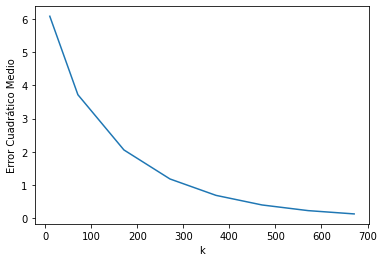

In [28]:
plt.plot(K_list,df_k.iloc[0])
plt.xlabel('k')
plt.ylabel('Error Cuadrático Medio')
plt.show()
plt.show()

Una vez elegido el modelo realizaremos la validación: 

In [30]:
als = Matrix_Factorization(n_iters = 15, k = 200, _lambda = 0.01)
als.fit(train, test)

In [31]:
# Esta es la matriz completa para poder hacer recomendaciones
MCompleta = als.predict()
MCompleta = pd.DataFrame(MCompleta, 
                         columns=ratings.columns, 
                         index=ratings.index)

In [32]:
def recomendaciones_id(Y, MCompleta, array_movies, bases_nombres_id, user, top=5):
    """
    Regresa id de las peliculas reomendadas dado un usuario
    Param: Recibe matriz con Nan, id del usurario y el top por default 5
    Return: Arreglo de ids de las películas sugeridas
    """
    
    # ------------------------------------ Para nuevas recomendaciones------------------------------
    # Se multiplica boleano con Y para poner en cero los ratings dados por el usuario
    nvos = []
    # Agregando índice
    for i in range (len(MCompleta)):
        # Se concatena el indice de la pélicula
        nvos.append([array_movies[i],MCompleta[i]*(~Y[i].any())])
    
    # nvos es un arreglo se pasa a dataframe para mejor manejabilidad
    nvos = pd.DataFrame(nvos)
    # se colocan nombres a las columnas
    nvos.columns = ['id_movie','rating_recom']
    # se ordenan de forma descendente
    nvos = nvos.sort_values(by=['rating_recom'], ascending=False)
    # Borrando 0
    nvos = nvos[(nvos[['rating_recom']] != 0).all(axis=1)]
    # Obteniendo el top
    recomendaciones = nvos['id_movie'].head(5).to_numpy()
    
    # ------------------------------------ Para recomendaciones incluyendo las existentes ----------
    # Incluyendo los datos calificados
    todos = []
    # Agregando índice
    for i in range (len(MCompleta)):
        # Se concatena el indice de la pélicula
        todos.append([array_movies[i], MCompleta[i]])
    # todos es un arreglo se pasa a dataframe para mejor manejabilidad
    todos = pd.DataFrame(todos)
    # se colocan nombres a las columnas
    todos.columns = ['id_movie','rating_recom']
    # se ordenan de forma descendente
    todos = todos.sort_values(by=['rating_recom'], ascending=False)
    # Obteniendo el top
    recomendaciones_t = todos['id_movie'].head(5).to_numpy()  
    
    # Por si se quiere imprimir desde aqui las recomendaciones
    print("Estás son las nuevas películas que te recomendamos usuario no. ", user)
    print(bases_nombres_id[bases_nombres_id['movieId'].isin(recomendaciones)][["movieId", "title"]])
    
    print("Estás películas te pueden interesar usuario no. ", user)
    print(bases_nombres_id[bases_nombres_id['movieId'].isin(recomendaciones_t)][["movieId", "title"]])
    
    return recomendaciones, recomendaciones_t

In [33]:
id_user = 1

In [34]:
rec_nvas, rec_todas = recomendaciones_id(np.array(ratings)[id_user-1], np.array(MCompleta)[id_user-1], 
                                         arr_movies, bases_nombres_id, id_user)

Estás son las nuevas películas que te recomendamos usuario no.  1
     movieId                                title
73      2194                     The Untouchables
104     1375  Star Trek III: The Search for Spock
201     1225                              Amadeus
260     1961                             Rain Man
944     2064                           Roger & Me
Estás películas te pueden interesar usuario no.  1
      movieId                          title
99       1371  Star Trek: The Motion Picture
201      1225                        Amadeus
712      1953          The French Connection
2037     2294                           Antz
3291     1172                Cinema Paradiso


In [35]:
# Películas que no ha visto
print("Estás son las nuevas películas que te recomendamos usuario no. ", id_user)
bases_nombres_id[bases_nombres_id['movieId'].isin(rec_nvas)][["movieId", "title"]]

Estás son las nuevas películas que te recomendamos usuario no.  1


,movieId,title
73,2194,The Untouchables
104,1375,Star Trek III: The Search for Spock
201,1225,Amadeus
260,1961,Rain Man
944,2064,Roger & Me


In [36]:
# Películas que ya vio
print("Estás películas te pueden interesar usuario no. ", id_user)
bases_nombres_id[bases_nombres_id['movieId'].isin(rec_todas)][["movieId", "title"]]

Estás películas te pueden interesar usuario no.  1


,movieId,title
99,1371,Star Trek: The Motion Picture
201,1225,Amadeus
712,1953,The French Connection
2037,2294,Antz
3291,1172,Cinema Paradiso


In [37]:
ratings_small = pd.read_csv('ratings_small.csv')

In [38]:
def desempenio_NDCG(ratings, user):
    """
    Evaluar el desempeño para un usuario
    :param user: usuario a evaluar
    :return ndcg: normalized discounted cumulative gain
    """
    
    rating_1 = ratings.loc[user]
    rating_user = rating_1[rating_1!=0]
    suma_dcg = 0
    suma_idcg = 0
    for i in range(0, len(rating_user)):
        suma_dcg += rating_user[i] / np.log2(i+1 + 1)
        suma_idcg += (pow(2,rating_user[i]) - 1) / np.log2(i+1 + 1)

    ndcg = round(suma_dcg / suma_idcg,2)
    
    return ndcg

In [39]:
# Probemos para el usuario 1
desempenio_NDCG(ratings, id_user)

0.43

In [40]:
# Obtengamos  el desempeño para todos los usuarios
def obtain_ndcg_all_users(ratings):
    ndcg = {}
    
    for user in ratings.index:
        ndcg.update({user:desempenio_NDCG(ratings, user)})
        #ndcg[user] desempenio_NDCG(Y_0, id_user)
    return ndcg

In [41]:
ndcg = obtain_ndcg_all_users(MCompleta)

In [42]:
ndcg_Y_0 = obtain_ndcg_all_users(ratings)

In [46]:
ndcg,ndcg_Y_0

({1: 1.35,
  2: 0.63,
  3: 0.76,
  4: 0.21,
  5: 0.54,
  6: 0.89,
  7: 0.5,
  8: 0.42,
  9: 0.75,
  10: 0.82,
  11: 0.93,
  12: 1.15,
  13: 0.84,
  14: 1.19,
  15: 0.34,
  16: 0.87,
  17: 0.24,
  18: 0.74,
  19: 0.29,
  20: 0.51,
  21: 0.46,
  22: 0.37,
  23: 0.28,
  24: 0.89,
  25: 0.97,
  26: 0.35,
  27: 0.65,
  28: 0.82,
  29: 1.26,
  30: 0.25,
  31: 0.48,
  32: 0.64,
  33: 0.54,
  34: 0.28,
  35: 1.34,
  36: 0.53,
  37: 0.97,
  38: 0.29,
  39: 0.61,
  40: 0.64,
  41: 0.3,
  42: 0.45,
  43: 0.65,
  44: 0.98,
  45: 1.17,
  46: 0.9,
  47: 0.59,
  48: 0.31,
  49: 0.69,
  50: 0.69,
  51: 1.12,
  52: 0.83,
  53: 1.06,
  54: 0.98,
  55: 0.7,
  56: 0.26,
  57: 0.24,
  58: 0.95,
  59: 0.54,
  60: 0.8,
  61: 0.42,
  62: 0.91,
  63: 0.32,
  64: 0.62,
  65: 0.91,
  66: 0.58,
  67: 0.41,
  68: 0.51,
  69: 0.33,
  70: 0.31,
  71: 1.05,
  72: 0.52,
  73: 0.3,
  74: 0.69,
  75: 0.47,
  76: 1.3,
  77: 0.35,
  78: 0.22,
  79: 0.95,
  80: 1.11,
  81: 0.26,
  82: 0.57,
  83: 0.26,
  84: 0.5,
  85: 0.4